In [592]:
from importlib import reload
import os
import numpy as np
import time
from tqdm import trange
from pulsestreamer import *
from nidaqmx import *

import analysis
reload(analysis)
from analysis import *

import measurement
reload(measurement)
from measurement import *

In [585]:
# loading the local Pulse Streamer and NIDAQmx
IPaddress = findPulseStreamers(search_serial='')[0][0]
pulser = PulseStreamer(IPaddress)

DAQ_device = nidaqmx.system.System.local().devices[0]
device_name = DAQ_device.terminals[0:1][0][1:5]
print(f'NIDAQmx device name : {device_name}')

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
NIDAQmx device name : Dev1


In [614]:
specs_ports = {'laserNum' : 1, 'gateStart' : 5, 'source' : 7}

specs_delay = {'rising_delay' : 2,'gatelen' :  6, 'laserontime' :  31,'delay_pad' :  2,
               'delay_shift' :  2,'gatesourcedelay' : 2}
specs_t1 = {'rising_delay' : 20,'gatelen' : 2e3, 'laserontime' : 25e3,'delay_pad' : 20,
            'delay_shift' : 50e3,'gatesourcedelay' : 5,'evolution_time' : 1e6}
specs_snr = {'rising_delay' : 20,'gatelen' : 1.5e3, 'laserontime' : 20e3,'delay_pad' : 20,
             'delay_shift' : (20e3-1.5e3)/10,'gatesourcedelay' : 5,'evolution_time' : 1.0e6}
specs_snr_new = {'rising_delay' : 20,'gatelen' : 1.5e3, 'laserontime' : 20e3,'delay_pad' : 20,
             'delay_shift' : (20e3-1.5e3)/10,'gatesourcedelay' : 5,'evolution_time' : 1e6}

specs_lifetime = {'rising_delay' : 2,'gatelen' : 2, 'laserontime' : 25,'laserofftime' : 50,
                  'delay_pad' : 2,'delay_shift' : 2,'gatesourcedelay' : 2}  
specs_t1_ir = {'rising_delay' : 20,'gatelen' : 2e3, 'laserontime' : 25e3,'delay_pad' : 20,
            'delay_shift' : 45e3,'gatesourcedelay' : 5,'evolution_time' : 0.45e6,'irontime' : 1e3,'irport' : 3}
specs_t1_simple = {'rising_delay' : 20,'gatelen' : 2e3, 'laserontime' : 5e3,'delay_pad' : 20,
            'delay_shift' : 35e3,'gatesourcedelay' : 5,'evolution_time' : 0.35e6}
specs_t1_new = {'rising_delay' : 20,'gatelen' : 2e3, 'laserontime' : 10e3,'delay_pad' : 20,
            'delay_shift' : 80e3,'gatesourcedelay' : 5,'evolution_time' : 0.80e6}

In [616]:
total_specs = merge(specs_ports,specs_snr_new)

In [618]:
# plot_sequence(pulser=pulser,exp_name='snr_new',specifications=total_specs)

In [620]:
avg_data,time_axis = measure(pulser,DAQ_device,device_name,exp_name = 'snr_new',
                   samples=2000,averages=15,specifications=total_specs)

number of steps : 10
Pixel : 40000
creating sequence
starting DAQ
Preparing Ni Daq for the experiment
callback number in beginning: 0


  0%|          | 0/15 [00:00<?, ?it/s]

1
2
3
4
5
6
7
8
9
10


  7%|▋         | 1/15 [00:21<04:59, 21.39s/it]

callback number after 1-th average end: 10
1
2
3
4
5
6
7
8
9
10


 13%|█▎        | 2/15 [00:42<04:38, 21.40s/it]

callback number after 2-th average end: 20
1
2
3
4
5
6
7
8
9
10


 20%|██        | 3/15 [01:04<04:16, 21.40s/it]

callback number after 3-th average end: 30
1
2
3
4
5
6
7
8
9
10


 27%|██▋       | 4/15 [01:25<03:55, 21.39s/it]

callback number after 4-th average end: 40
1
2
3
4
5
6
7
8
9
10


 33%|███▎      | 5/15 [01:46<03:33, 21.39s/it]

callback number after 5-th average end: 50
1
2
3
4
5
6
7
8
9
10


 40%|████      | 6/15 [02:08<03:12, 21.39s/it]

callback number after 6-th average end: 60
1
2
3
4
5
6
7
8
9
10


 47%|████▋     | 7/15 [02:29<02:51, 21.38s/it]

callback number after 7-th average end: 70
1
2
3
4
5
6
7
8
9
10


 53%|█████▎    | 8/15 [02:51<02:29, 21.38s/it]

callback number after 8-th average end: 80
1
2
3
4
5
6
7
8
9
10


 60%|██████    | 9/15 [03:12<02:08, 21.39s/it]

callback number after 9-th average end: 90
1
2
3
4
5
6
7
8
9
10


 67%|██████▋   | 10/15 [03:33<01:46, 21.39s/it]

callback number after 10-th average end: 100
1
2
3
4
5
6
7
8
9
10


 73%|███████▎  | 11/15 [03:55<01:25, 21.39s/it]

callback number after 11-th average end: 110
1
2
3
4
5
6
7
8
9
10


 80%|████████  | 12/15 [04:16<01:04, 21.39s/it]

callback number after 12-th average end: 120
1
2
3
4
5
6
7
8
9
10


 87%|████████▋ | 13/15 [04:38<00:42, 21.39s/it]

callback number after 13-th average end: 130
1
2
3
4
5
6
7
8
9
10


 93%|█████████▎| 14/15 [04:59<00:21, 21.39s/it]

callback number after 14-th average end: 140
1
2
3
4
5
6
7
8
9
10


100%|██████████| 15/15 [05:20<00:00, 21.39s/it]

callback number after 15-th average end: 150
Total Run : 150
Total Counts & Counts in one average : (600000, 40000)
Crosscheck number of averges= 15
returning averaged counts and time_axis


In [622]:
dict_args = {'avg_data':avg_data,'time_axis':time_axis}

In [624]:
root_directory = os.getcwd()
print(f'root directory : {root_directory}')

root directory : C:\Users\Administrator\OneDrive\Desktop\T1_measurement\atanu_github\Instrument_Automation\Experimental_Applications


In [626]:
year = time.ctime()[-4:]
date = time.ctime()[4:10].replace(' ','_')
current_time = time.ctime()[-13:-8].replace(':','_')

folder_path = root_directory+f'/exp_data/{year}/{date}/microdiamonds/snr_new/525nm/optimization/avgs_15/samples_2000/laser_20e3/'
file_name = f'[{current_time}]_gate_1500ns.npz'

total_path = npz_save(folder_path,file_name,**dict_args)

saving data_file '[16_04]_gate_1500ns.npz' is successful!



In [628]:
load_data = dict(np.load(total_path))

In [630]:
samples=int(input('Enter the no of samples'))

# time_axis,signal_photon,reference_samples,signal_samples = data_to_time_signal(load_data,samples,first='signal')
time_axis,signal_photon,reference_samples,signal_samples = data_to_time_signal(load_data,samples,first='reference')

Enter the no of samples 2000


In [ ]:
# steps=int(input('Enter the no of steps'))
# samples=int(input('Enter the no of samples'))

# # Separating Reference and Signal and averaging over Samples
# reference_samples = np.mean(np.reshape(load_data['avg_data'][::2],(steps,samples)),axis=1)
# signal_samples = np.mean(np.reshape(load_data['avg_data'][1::2],(steps,samples)),axis=1)
# signal_photon = signal_samples/reference_samples

Lifetime in nano_second is : 769114980.1 ± 434174957384.8



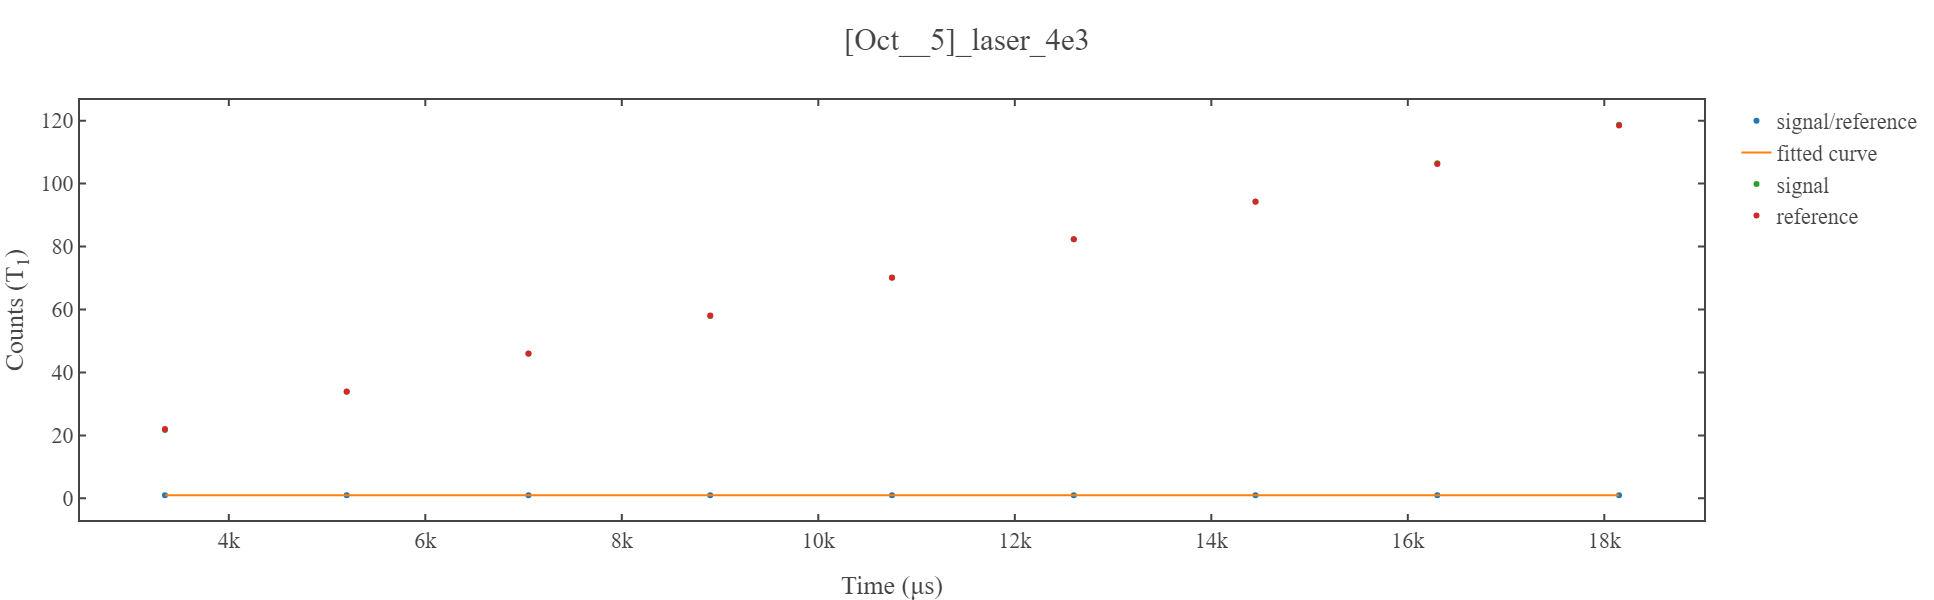

In [632]:
x=time_axis[1:]
y=signal_photon[1:]

x_fit,y_fit,coefficient,error_bars = fit_func(x,y,fit_range=False,func='exp',guess_params=np.array([0.7,0.9,0.5e6]))

fig1 = simple_plot(x,y,show=False,x_name = "Time (&mu;s)",y_name = "Counts (T<sub>1</sub>)",mode='markers',title=f'{date}',curve_name='signal/reference')
fig2 = simple_plot(x_fit,y_fit,show=False,x_name = "Time (&mu;s)",y_name = "Counts (T<sub>1</sub>)",mode='lines',title=f'{date}',curve_name='fitted curve')
fig3 = simple_plot(x,signal_samples[1:],show=False,x_name = "Time (&mu;s)",y_name = "Counts (T<sub>1</sub>)",mode='markers',title=f'{date}',curve_name='signal')
fig4 = simple_plot(x,reference_samples[1:],show=False,x_name = "Time (&mu;s)",y_name = "Counts (T<sub>1</sub>)",mode='markers',title=f'{date}',curve_name='reference')


add_figures([fig1,fig2,fig3,fig4],show=True,x_name = "Time (&mu;s)",y_name = "Counts (T<sub>1</sub>)",title=f'[{date}]_laser_4e3')

## Add calibrations, specifications and few reference plots

oct 5 

only microdiamonds with t1 sequence
1. laserontime_25e3 : [71854.3 ± 29925.6,46497.9 ± 12325.3] (sig and sig/ref are exponentially increasing but ref is decreasing. However, now the ref is more than sig and almost constant. Sig has not achieved the steady value.)
2. laserontime_20e3 : [54644.0 ± 20095.1, 54254.2 ± 19319.4] (similar to 25e3.)
3. laserontime_15e3 : [224465.4 ± 227911.2,373035.0 ± 653140.6] (similar to previous cases, although now sig and ref are approching each other slowly.)
4. laserontime_10e3 : [1342262815.2 ± 1463551777574.4,29033569.0 ± 2795046276.8] (they approched more and now it seems there is some transition happening.)
5. laserontime_5e3 : [58447.4 ± 7026.0, 53774.8 ± 5919.2] (now ref crossed sig with similar features of others.)
6. laserontime_4e3 : [75602.1 ± 14953.5,66403.5 ± 18132.0] (ref is inside of sig)
7. laserontime_3e3 : [43610.4 ± 10700.5, 43051.9 ± 5937.5] (ref is in the middle of sig and sig has gone more scattered.)

oct 4

1. with only thin glass slide without cover slip.